In [ ]:
# for export pdf
import matplotlib.pyplot
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

# <!--
# 1. 本文档 pdf 版本生成
# ```bash
# jupyter nbconvert --to pdf 02_firedrake_intro.ipynb
# ```
# -->

# Solving Poisson equation

## Dirichlet 问题

求解如下 Poisson 方程
\begin{equation}
\begin{aligned}
- \Delta u &= f   &&\quad{\rm in}\quad \Omega,\\
         u &= g_D &&\quad{\rm on} \quad \partial\Omega_D, \\
         \frac{\partial u}{\partial n} &= g_N &&\quad{\rm on} \quad \partial\Omega_N,
\end{aligned}
\end{equation}
其中 $\partial\Omega_D\cap\partial\Omega_N = \partial\Omega$, 并且 $\int_{\partial\Omega_D} {\rm d}s \ne 0$.

__试验和测试函数空间__

\begin{equation}
\begin{aligned}
H_E^1 := \{u \in H^1 \,|\, u = g_D \ \ \text{on}\ \ \partial\Omega_D\}\\
H^1_{E_0} := \{u \in H^1 \,|\, u = 0 \ \ \text{on}\ \ \partial\Omega_D\}\\
\end{aligned}
\end{equation}

__变分问题__

求解 $u \in H_E^1$, 使得
\begin{equation}
    \int_\Omega \nabla u\cdot\nabla v = \int_\Omega f v + \int_{\partial\Omega_N} g_N v \qquad \forall v \in H^1_{E_0}.
\end{equation}


### 简单算例

+ 区域 $\Omega = (0, 1)\times(0, 1)$, 
+ 右端项 $f = \sin(\pi x)\sin(\pi y)$
+ 边界条件: $\partial\Omega_N = \emptyset, \quad g_D = 0$ (齐次 Dirichlet)

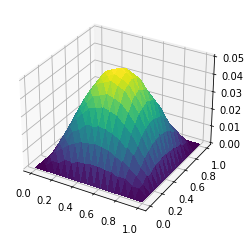

In [2]:
from firedrake import *
import matplotlib.pyplot as plt

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx                    # or f*v*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')
solve(a == L, u_h, bcs=bc)          # 有不同求解方式， 可添加求解参数
# solve(a == L, u_h, bcs=(bc,))

fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
trisurf(u_h, axes=ax)

### Firedrake 内建网格生成函数

UnitDiskMesh, IntervalMesh, RectangleMesh, CubeMesh ...

In [3]:
from firedrake import utility_meshes
from pprint import pprint

pprint(utility_meshes.__all__)

['IntervalMesh',
 'UnitIntervalMesh',
 'PeriodicIntervalMesh',
 'PeriodicUnitIntervalMesh',
 'UnitTriangleMesh',
 'RectangleMesh',
 'TensorRectangleMesh',
 'SquareMesh',
 'UnitSquareMesh',
 'PeriodicRectangleMesh',
 'PeriodicSquareMesh',
 'PeriodicUnitSquareMesh',
 'CircleManifoldMesh',
 'UnitDiskMesh',
 'UnitTetrahedronMesh',
 'BoxMesh',
 'CubeMesh',
 'UnitCubeMesh',
 'PeriodicBoxMesh',
 'PeriodicUnitCubeMesh',
 'IcosahedralSphereMesh',
 'UnitIcosahedralSphereMesh',
 'OctahedralSphereMesh',
 'UnitOctahedralSphereMesh',
 'CubedSphereMesh',
 'UnitCubedSphereMesh',
 'TorusMesh',
 'CylinderMesh']


__查看帮助__
1. `?<fun-name>`
2. `help(<fun-name>)`

In [4]:
?CubeMesh

Signature:     
CubeMesh(
    nx,
    ny,
    nz,
    L,
    reorder=None,
    distribution_parameters=None,
    comm=<mpi4py.MPI.Intracomm object at 0x7fa88bdc2f10>,
    name='firedrake_default',
)
Call signature: CubeMesh(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction CubeMesh at 0x7fa884559c70>
File:           ~/software/firedrake-mini-petsc/src/firedrake/firedrake/utility_meshes.py
Docstring:     
Generate a mesh of a cube

:arg nx: The number of cells in the x direction
:arg ny: The number of cells in the y direction
:arg nz: The number of cells in the z direction
:arg L: The extent in the x, y and z directions
:kwarg reorder: (optional), should the mesh be reordered?
:kwarg comm: Optional communicator to build the mesh on (defaults to
    COMM_WORLD).
:kwarg name: Optional name of the mesh.

The boundary surfaces are numbered as follows:

* 1: plane x == 0
* 2: plane x == L
* 3: plane y == 0
* 4: plane y == L
* 5: plane z == 0
* 6: plane z 

### UFL 表达式

#### 算子

DOC: https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#tensor-algebra-operators)

1. `dot`
    
    张量缩并, `dot(u, v)` 对 `u` 的最后一个维度和 `v` 的第一个维度做缩并.
    
2. `inner`
    
    张量内积(分量对应乘积之和). 对第二个张量取复共轭.
    
3. `grad` and `nabla_grad`
    1. `grad`
        
        对张量求导, 新加维度为最后一个维度.
        
        1. scalar
            $$
            {\rm grad}(u) = \nabla u = \frac{\partial u}{\partial x_i}{\bf e}_i
            $$
            
        2. vector
            $$
            {\rm grad}({\bf v}) = \nabla {\bf v} = \frac{\partial v_i}{\partial x_j}{\bf e}_i \otimes {\bf e}_j
            $$
            
        3. tensor

            设 $\bf T$ 为秩为 $r$ 的张量, 那么
            $$
            {\rm grad}({\bf T}) = \nabla {\bf T} = \frac{\partial {\bf T}_\ell}{\partial x_i}{\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_r}\otimes {\bf e}_{i}
            $$
            其中 $\ell$ 是长度为 $r$ 的多指标 (multi-index).
            
    2. `nabla_grad`

        **类似 `grad`, 不过新加维度为第一个维度**
        
        1. scalar (same with `grad`)
            $$
            {\rm nabla\_grad}(u) = \nabla u = \frac{\partial u}{\partial x_i}{\bf e}_i
            $$
        2. vector
            $$
            {\rm nabla\_grad}({\bf v}) = (\nabla {\bf v})^T = \frac{\partial v_j}{\partial x_i}{\bf e}_i \otimes {\bf e}_j
            $$
        3. tensor

            设 $\bf T$ 为秩为 $r$ 的张量, 那么
            $$
            {\rm nabla\_grad}({\bf T}) = \frac{\partial {\bf T}_\ell}{\partial x_i}{\bf e}_{i}\otimes {\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_r}
            $$
            
4. `div` and `nabla_div`
    1. `div`

        **对最后一个维度的偏导数进行缩并.**

        
        设 $\bf T$ 为秩为 $r$ 的张量, 那么
        $$
        {\rm div}({\bf T}) = \sum_i\frac{\partial {\bf T}_{\ell_1\ell_2\cdots\ell_{r-1} i}}{\partial x_i}{\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_{r-1}}
        $$
        
    2. `nabla_div`

        **类似 `div`, 不过对第一个维度的偏导数进行缩并.**

5. 两个表达式:
    1. $(u\cdot\nabla) v$ → `dot(u, nabla_grad(v))` or `dot(grad(v), u)`
    2. $\Delta u$ → `div(grad(u))`

#### 非线性函数

https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#basic-nonlinear-functions

+ `abs`, `sign`
+ `pow`, `sqrt`
+ `exp`, `ln`
+ `cos`, `sin`, ...
+ ...

#### Measures

1. `dx`: the interior of the domain $\Omega$ (`dx`, cell integral);
2. `ds`: the boundary $\partial\Omega$ of $\Omega$ (`ds`, exterior facet integral);
3. `dS`: the set of interior facets $\Gamma$ (`dS`, interior facet integral).

在区域内部的边界上积分时, 需要使用 `dS` 并使用限制算子 `+` 或 `-`, 如:

```python
a = u('+')*v('+')*dS
```

### 函数空间创建


+ FunctionSpace 标量函数空间
+ VectorFunctionSpace 向量函数空间
+ MixedFunctionSpace 混合空间

支持的单元类型: CG, DG, RT, BDM, ... (https://firedrakeproject.org/variational-problems.html#supported-finite-elements)

### 线性方程组参数设置

#### 三种求解方程组 Coding 方式

仍然以上述 Poisson 方程为例: [Possion Example](possion_example1.py)

可以使用 `%load` 加载文件内容到 notebook 中
```pyhon
%load possion_example1.py
```

In [5]:
# %load possion_example1.py
from firedrake import *
from firedrake.petsc import PETSc

methods = ['solve', 
           'assemble', 
           'LinearVariationalSolver']

# Get commandline args
opts = PETSc.Options()
case_index = opts.getInt('case_index', default=0)
if case_index < 0 or case_index > 2:
    raise Exception('Case index must be in [0, 2]')
    
case = methods[case_index]

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx                    # or f*v*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')

if case == 'solve':
    PETSc.Sys.Print('Case: solve')
    # solve(a == L, u_h, bcs=bc)
    solve(a == L, u_h, bcs=bc,
          solver_parameters={           # 设置方程组求解算法
              # 'ksp_view': None,
              'ksp_type': 'preonly', 
              'pc_type': 'lu',
              'pc_factor_mat_solver_type': 'mumps'
          },
          options_prefix='test'         # 命令行参数前缀
         )
    

elif case == 'assemble':
    PETSc.Sys.Print('Case: assemble')
    A = assemble(a, bcs=bc)
    b = assemble(L, bcs=bc)
    solve(A, u_h, b,
          options_prefix='test'
         )

elif case == 'LinearVariationalSolver':
    PETSc.Sys.Print('Case: LinearVariationalSolver')
    problem = LinearVariationalProblem(a, L, u_h, bcs=bc)
    solver = LinearVariationalSolver(problem, 
                                     solver_parameters={
                                         # 'ksp_view': None,
                                         'ksp_monitor': None,
                                         'ksp_converged_reason': None,
                                         'ksp_type': 'cg',
                                         'pc_type': 'none'
                                     }, 
                                     options_prefix='test')

    solver.solve()
else:
    raise Exception(f'Unknow case: {case}')

File('pvd/poisson_example.pvd').write(u_h)
print('Done!')

Case: solve
Done!


+ KSP [scalable linear equations solvers, Krylov subspace solver with preconditioner](https://petsc.org/main/docs/manualpages/KSP/index.html) 
    
    参数: https://petsc.org/main/docs/manual/ksp/#tab-kspdefaults

+ PC
    
    参数: https://petsc.org/main/docs/manual/ksp/#tab-pcdefaults
    
    + 外部包 pc 参数: https://petsc.org/main/docs/manual/ksp/#tab-externaloptions

#### 命令行参数

__参数说明__

1. `mat_type`: `aij` 或 `matfree`
1. `ksp_type`: 设置迭代法
2. `pc_type`: 设置预处理方式
3. `ksp_monitor`: 输出每步迭代的残差
4. `ksp_view`: 迭代完成后输出 ksp 的设置等内容
5. `ksp_converged_reason`: 输出收敛的原因


__LU 分解参数设置__

Ref: https://petsc.org/release/src/dm/impls/stag/tutorials/ex4.c.html

```
-ksp_type -pc_type lu -pc_factor_mat_solver_type mumps  
```

这里 `pc_factor_mat_solver_type` 设置 LU 分解使用的 package (如 petsc, mumps, umfpack, superlu).
其他选项见: https://petsc.org/release/docs/manualpages/Mat/MatSolverType/

__多重网格__

https://nbviewer.org/github/firedrakeproject/firedrake/blob/master/docs/notebooks/07-geometric-multigrid.ipynb

__终端演示__: 设置命令行参数控制线性方程组的求解

```bash
python possion_example1.py -case solve \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type cg -pc_type jacobi

python possion_example1.py -case assemble \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type gmres -pc_type none

python possion_example1.py -case LinearVariationalSolver \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type minres -pc_type none
```

### 查看高斯积分公式

In [6]:
import FIAT
import finat

ref_cell = FIAT.reference_element.UFCTriangle()

from pprint import pprint
ret = {}
for i in range(0, 5):
    qrule = finat.quadrature.make_quadrature(ref_cell, i)
    ret[i] = {'points': qrule.point_set.points, 'weights': qrule.weights}
    
pprint(ret)

{0: {'points': array([[0.33333333, 0.33333333]]), 'weights': array([0.5])},
 1: {'points': array([[0.33333333, 0.33333333]]), 'weights': array([0.5])},
 2: {'points': array([[0.16666667, 0.16666667],
       [0.16666667, 0.66666667],
       [0.66666667, 0.16666667]]),
     'weights': array([0.16666667, 0.16666667, 0.16666667])},
 3: {'points': array([[0.65902762, 0.23193337],
       [0.65902762, 0.10903901],
       [0.23193337, 0.65902762],
       [0.23193337, 0.10903901],
       [0.10903901, 0.65902762],
       [0.10903901, 0.23193337]]),
     'weights': array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333])},
 4: {'points': array([[0.81684757, 0.09157621],
       [0.09157621, 0.81684757],
       [0.09157621, 0.09157621],
       [0.10810302, 0.44594849],
       [0.44594849, 0.10810302],
       [0.44594849, 0.44594849]]),
     'weights': array([0.05497587, 0.05497587, 0.05497587, 0.11169079, 0.11169079,
       0.11169079])}}


#### 显示选择积分公式

In [7]:
set_log_level(CRITICAL) # Disable warnings

mesh = RectangleMesh(nx=8, ny=8, Lx=1, Ly=1)
V = FunctionSpace(mesh, 'CG', 1)
cell = V.finat_element.cell

x, y = SpatialCoordinate(mesh)
f = x**3 + y**4 + x**2*y**2

for i in range(0, 5):
    qrule = finat.quadrature.make_quadrature(ref_cell, i)
    ret[i] = {'points': qrule.point_set.points, 'weights': qrule.weights}
    v = assemble(f*dx(rule=qrule))
    print(f'degree={i}, v = {v}', )

print('Default:  v =', assemble(f*dx(rule=None)))

degree=0, v = 0.5579329125675148
degree=1, v = 0.5579329125675148
degree=2, v = 0.5611099431544168
degree=3, v = 0.5611100938585061
degree=4, v = 0.5611111111111102
Default:  v = 0.5611111111111102


### 边界条件设置

__内建网格边界编号__

`RectangleMesh`:
  
* 1: plane x == 0
* 2: plane x == Lx
* 3: plane y == 0
* 4: plane y == Ly

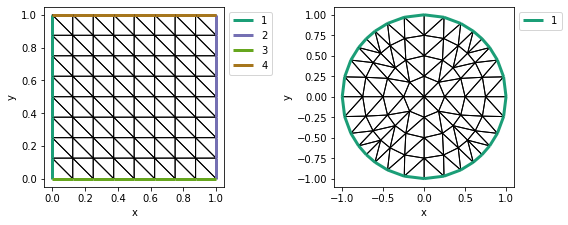

In [8]:
from firedrake import *
import matplotlib.pyplot as plt


def plot_mesh_with_label(mesh, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=[4, 4])
    triplot(mesh, axes=axes, boundary_kw={'lw': 3})
    axes.set_aspect(aspect='equal')
    # ax.set_axis_off()
    axes.legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes.set_xlabel('x')
    axes.set_ylabel('y')

N = 8
rect_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
circ_mesh = UnitDiskMesh(2)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_mesh_with_label(rect_mesh, axes=ax[0])
plot_mesh_with_label(circ_mesh, axes=ax[1])
fig.tight_layout()

__设置边界条件__

In [9]:
N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)

g = x*2 + y*2
V = FunctionSpace(test_mesh, 'CG', degree=1)


def trisurf_bdy_condition(V, g, sub_domain, axes=None):
    bc = DirichletBC(V, g=g, sub_domain=sub_domain)
    g = Function(V)
    bc.apply(g)

    trisurf(g, axes=axes)
    if axes:
        axes.set_xlabel('x')
        axes.set_ylabel('y')
        axes.set_title(sub_domain)

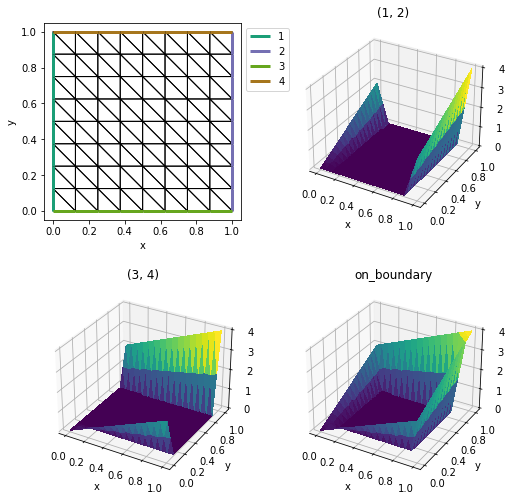

In [10]:
# plot the mesh and boundry conditons
fig, ax = plt.subplots(2, 2, figsize=[7, 7], subplot_kw=dict(projection='3d'))
ax = ax.flat

ax[0].remove()
ax[0] = fig.add_subplot(2, 2, 1)
plot_mesh_with_label(test_mesh, ax[0])

sub_domains = [(1, 2), (3, 4), 'on_boundary']
for i in range(3):
    trisurf_bdy_condition(V, g=g, sub_domain=sub_domains[i], axes=ax[i+1])
fig.tight_layout()

### [Gmsh](https://gmsh.info/) 网格边界设置

需要在 gmsh 中给相应的边界加上标签 (Physical Tag)

_gmsh gui 演示_: 生成如下 `geo` 文件和 `msh` 文件

File: `gmsh/rectangle.geo`
```geo
// Gmsh project created on Tue Sep 30 15:09:53 2022
SetFactory("OpenCASCADE");
//+
Rectangle(1) = {0, 0, 0, 1, 1, 0};
//+
Physical Curve("lower", 1) = {1};
//+
Physical Curve("upper", 2) = {3};
//+
Physical Curve("left", 3) = {4};
//+
Physical Curve("right", 4) = {2};
//+
Physical Surface("domain", 1) = {1};
```

Gmsh file: `gmsh/rectangle.msh`

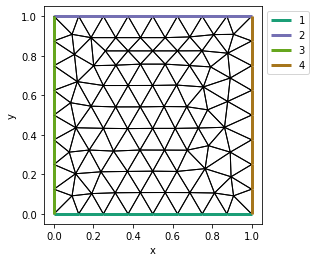

In [11]:
# opts = PETSc.Options()
# opts.insertString('-dm_plex_gmsh_mark_vertices True')

gmsh_mesh = Mesh('gmsh/rectangle.msh')
plot_mesh_with_label(gmsh_mesh)

_使用 gmsh 的 python SDK_: [gmsh](https://pypi.org/project/gmsh/) 或者 [pygmsh](https://pypi.org/project/pygmsh/)

example: [make_mesh_circle_in_rect.py](make_mesh_circle_in_rect.py)

In [12]:
from make_mesh_circle_in_rect import make_circle_in_rect

Info    : Writing 'gmsh/circle_in_rect.msh'...
Info    : Done writing 'gmsh/circle_in_rect.msh'


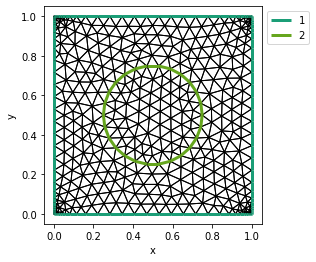

In [13]:
h = 1/16
filename = 'gmsh/circle_in_rect.msh'
make_circle_in_rect(h, filename, p=3, gui=False)

cr_mesh = Mesh(filename)
plot_mesh_with_label(cr_mesh)

## 纯 Neumann 边界条件

求解如下 Poisson 方程
\begin{equation}
\begin{aligned}
- \Delta u &= f   &&\quad{\rm in}\quad \Omega,\\
         \frac{\partial u}{\partial n} &= g_N &&\quad{\rm on} \quad \partial\Omega,
\end{aligned}
\end{equation}

__变分问题__

求 $u \in H^1$, 且 $\int_\Omega u = 0$ 使得
\begin{equation}
    \int_\Omega \nabla u\cdot\nabla v = \int_\Omega f v + \int_{\partial\Omega} g_N v \qquad \forall v \in H^1.
\end{equation}

__兼容性条件__

$$
\int_\Omega f v + \int_{\partial\Omega} g_N v = 0
$$

### Use nullspace of solve

    Residual norms for test1_ solve.
    0 KSP Residual norm 7.133205795309e-01 
    1 KSP Residual norm 4.463009742158e+01 
    Residual norms for test2_ solve.
    0 KSP Residual norm 5.188828525840e-01 
    1 KSP Residual norm 1.256141430046e-14 


Text(0.5, 0.92, 'transpose nullspace')

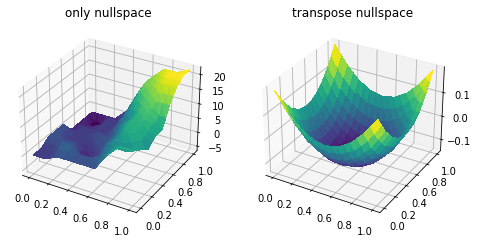

In [14]:
N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

subdomain_id = None # None for all boundray, 或者单个编号 如 1, 或者使用 list 或 tuple 如: (1, 2)

if True:
    # 不满足兼容性条件
    g = Constant(1)
else:
    # 满足兼容性条件
    L = assemble(1*ds(domain=test_mesh, subdomain_id=subdomain_id))
    g = Constant(-assemble(f*dx)/L)

V = FunctionSpace(test_mesh, 'CG', degree=1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx + inner(g, v)*ds(subdomain_id=subdomain_id)

u1_h = Function(V, name='u1_h')

nullspace = VectorSpaceBasis(constant=True)

solve(a == L, u1_h, 
      solver_parameters={
          # 'ksp_view': None,
          'ksp_monitor': None,
      },
      options_prefix='test1',
      nullspace=nullspace, 
      transpose_nullspace=None)

u2_h = Function(V, name='u2_h')
solve(a == L, u2_h,
      solver_parameters={
          # 'ksp_view': None,
          'ksp_monitor': None,
      },
      options_prefix='test2',
      nullspace=nullspace, 
      transpose_nullspace=nullspace)


fig, ax = plt.subplots(1, 2, figsize=[8, 4], subplot_kw=dict(projection='3d'))
trisurf(u1_h, axes=ax[0])
ax[0].set_title('only nullspace')
trisurf(u2_h, axes=ax[1])
ax[1].set_title('transpose nullspace')

### Using Lagrange multiplier

<!--__极值问题__
求 $u \in H^1 $ 满足
\begin{equation}
\begin{aligned}
    & u = \arg\min J(u)\\
    & J(u) = \frac12\int_\Omega |\nabla u|^2 - \int_\Omega f u - \int_{\partial\Omega} g_N u\\
    &\int_\Omega u = 0
\end{aligned}
\end{equation}

__等价问题__
\begin{equation}
\begin{aligned}
    & u, \mu = \arg\min \tilde J(u, \mu)\\
    & \tilde J(u, \lambda) = J(u) + \mu \int_\Omega u, \quad \mu\in \mathbb{R}\\
\end{aligned}
\end{equation}
-->

__变分问题__

求 $u\in H^1, \mu \in R$ 使得 
\begin{equation}
\begin{aligned}
    & \int_\Omega \nabla u \cdot \nabla v + \mu \int_\Omega v - \int_\Omega f v - \int_{\partial\Omega} g_N v = 0, \quad\forall \in H^1 \\
    & \eta \int_\Omega u = 0,\quad \forall \eta \in \mathbb{R}\\
\end{aligned}
\end{equation}

In [15]:
# %load possion_neumann_lagrange.py
from firedrake import *
from firedrake.petsc import PETSc

opts = PETSc.Options()
N = opts.getInt('N', default=8)
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)

x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g_N = Constant(1)

V = FunctionSpace(test_mesh, 'CG', degree=1)
R = FunctionSpace(test_mesh, 'R', 0)

W = MixedFunctionSpace([V, R]) # or W = V*R

u, mu = TrialFunction(W)
v, eta = TestFunction(W)

a = inner(grad(u), grad(v))*dx + inner(mu, v)*dx + inner(u, eta)*dx
L = inner(f, v)*dx + inner(g_N, v)*ds

w_h = Function(W)
solve(a == L, w_h, options_prefix='test')

u_h, mu_h  = w_h.split()

filename = 'pvd/u_h_neumann.pvd'
PETSc.Sys.Print(f'Write pvd file: {filename}')
File(filename).write(u_h)

Write pvd file: pvd/u_h_neumann.pvd


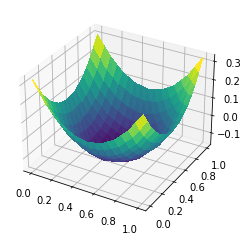

In [16]:
fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
trisurf(u_h, axes=ax)

__终端演示__

```bash
$ python possion_neumann_lagrange.py -test_ksp_monitor -test_ksp_converged_reason -N 64
Number of Dofs: 4226
firedrake:WARNING Real block detected, generating Schur complement elimination PC
    Residual norms for test_ solve.
    0 KSP Residual norm 2.501422711621e-01
    1 KSP Residual norm 1.747929427611e-01
    2 KSP Residual norm 1.071502741145e-14
  Linear test_ solve converged due to CONVERGED_RTOL iterations 2
Write pvd file: pvd/u_h_neumann.pvd

$ mpiexec -n 2 python possion_neumann_lagrange.py \
    -test_ksp_monitor -test_ksp_converged_reason -N 64
Number of Dofs: 4226
firedrake:WARNING Real block detected, generating Schur complement elimination PC
    Residual norms for test_ solve.
    0 KSP Residual norm 2.501422711621e-01
    1 KSP Residual norm 2.085403806063e-02
    2 KSP Residual norm 9.317076546546e-16
  Linear test_ solve converged due to CONVERGED_RTOL iterations 2
Write pvd file: pvd/u_h_neumann.pvd
```

## 计算收敛阶

+ 和真解对比
+ 和参考解对比
+ 相邻三层之间对比 (Cauchy 序列): [possion_convergence.py](possion_convergence.py)

### 生成网格序列

```python
base = RectangleMesh(N, N, 1, 1)
meshes = MeshHierarchy(test_mesh, refinement_levels=4)
```

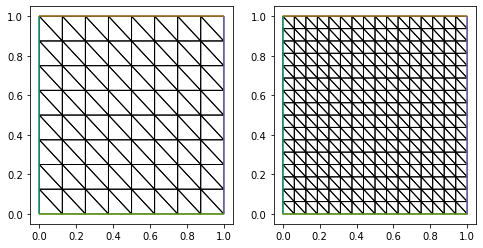

In [17]:
from firedrake import *
import matplotlib.pyplot as plt

N = 8
base = RectangleMesh(N, N, 1, 1)
meshes = MeshHierarchy(base, refinement_levels=3)

n = len(meshes)
m = min(2, n)
fig, ax = plt.subplots(1, m, figsize=[4*m, 4])
for i in range(m):
    triplot(meshes[i], axes=ax[i])

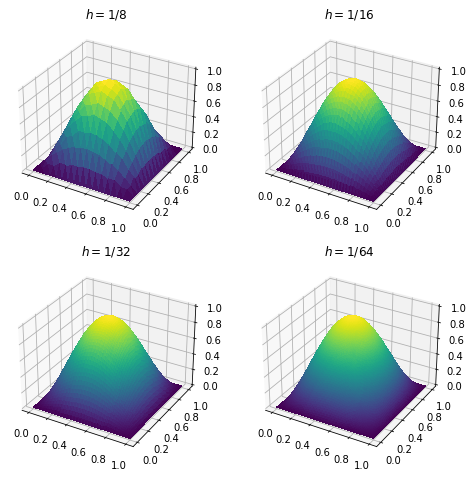

In [18]:
us = []
for mesh in meshes:
    x, y = SpatialCoordinate(mesh)
    f = sin(pi*x)*sin(pi*y)
    V = FunctionSpace(mesh, 'CG', degree=1)
    u = Function(V).interpolate(f)
    us.append(u)

m = min(4, n)
fig, ax = plt.subplots(2, 2, figsize=[4*2, 4*2], subplot_kw=dict(projection='3d'))
ax = ax.flat
for i in range(n):
    trisurf(us[i], axes=ax[i])
    ax[i].set_title(f'$h=1/{N*2**i}$')

### 投影到细网格上的空间中

目前 Firedrake 只能投影函数到相邻层的网格上 (由 MeshHierarchy 生成的网格), 和最密网格比较时可以多次投影, 直至最密网格, 然后比较结果.

下面我们仅比较相邻层的误差

In [19]:
errors = []
hs = []
for i, u in enumerate(us[:-1]):
    u_ref = us[i+1]
    u_inter = project(u, u_ref.function_space())
    error = errornorm(u_ref, u_inter)
    errors.append(error)
    hs.append(1/(N*2**i))

hs, errors

([0.125, 0.0625, 0.03125],
 [0.012284003199971324, 0.003100763810085325, 0.0007770614161052795])

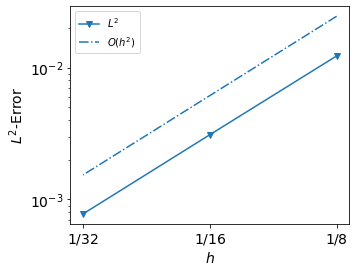

In [20]:
from intro_utils import plot_errors
plot_errors(hs, errors, expect_order=2)

### 插值到细网格上的空间中

+ VertexOnlyMesh:
+ PointCloud: https://github.com/lrtfm/fdutils

#### Example of `PointCloud`

Interpolate function `f1` on mesh `m1` to function `f2` on mesh `m2` 

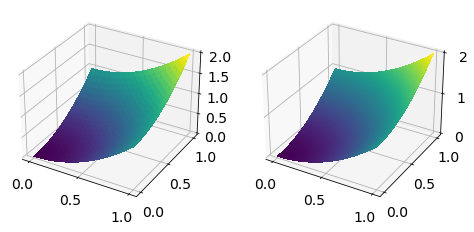

In [21]:
import firedrake as fd
from fdutils import PointCloud
from fdutils.tools import get_nodes_coords
import matplotlib.pyplot as plt

m1 = fd.RectangleMesh(10, 10, 1, 1)
V1 = fd.FunctionSpace(m1, 'CG', 2)
x, y = fd.SpatialCoordinate(m1)
f1 = fd.Function(V1).interpolate(x**2 + y**2)

m2 = fd.RectangleMesh(20, 20, 1, 1)
V2 = fd.FunctionSpace(m2, 'CG', 3)
f2 = fd.Function(V2)

points = get_nodes_coords(f2)
pc = PointCloud(m1, points, tolerance=1e-12)
f2.dat.data_with_halos[:] = pc.evaluate(f1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4], subplot_kw=dict(projection='3d'))
fd.trisurf(f1, axes=ax[0])
fd.trisurf(f2, axes=ax[1])

#### 计算误差

In [22]:
from fdutils.tools import errornorm as my_errornorm

my_errors_0 = []
for i, u in enumerate(us[:-1]):
    # 和相邻层结果比较
    my_errors_0.append(my_errornorm(u, us[i+1], tolerance=1e-12))

my_errors_0

[0.012284003212205772, 0.003100763847789638, 0.0007770614201377909]

In [23]:
from fdutils.tools import errornorm as my_errornorm

my_errors = []
for i, u in enumerate(us[:-1]):
    # 和最密层结果比较
    my_errors.append(my_errornorm(u, us[-1], tolerance=1e-12))

my_errors

[0.015349062780286471, 0.0037181920308195534, 0.0007770614201377909]

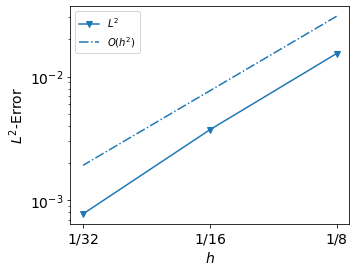

In [24]:
from intro_utils import plot_errors
plot_errors(hs, my_errors, expect_order=2)

## 构造等参元

Firedrake 中坐标是通过函数 `Function` 给出的, 可以通过更改该函数的值来移动网格或者构造等参元对应的映射.

### 移动网格

坐标的存储 (numpy 数组)
```python
mesh = RectangleMesh(10, 10, 1, 1)
mesh.coordinates.dat.data
mesh.coordinates.dat.data_ro
mesh.coordinates.dat.data_with_halos
mesh.coordinates.dat.data_ro_with_halos
```

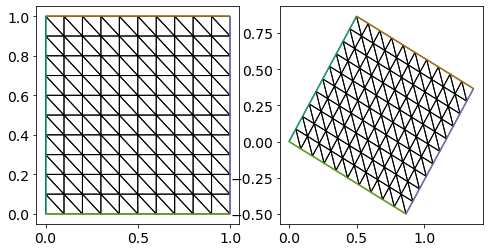

In [25]:
import numpy as np

# test_mesh = UnitDiskMesh(refinement_level=3)
test_mesh = RectangleMesh(10, 10, 1, 1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
handle = triplot(test_mesh, axes=ax[0])

theta = np.pi/6
R = np.array([[np.cos(theta), - np.sin(theta)], 
              [np.sin(theta),   np.cos(theta)]])

# test_mesh.coordinates.dat.datas[:] = test_mesh.coordinates.dat.data_ro[:]@R
test_mesh.coordinates.dat.data_with_halos[:] = test_mesh.coordinates.dat.data_ro_with_halos[:]@R

handle = triplot(test_mesh, axes=ax[1])

### 简单映射边界点

等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上.

```python
def make_high_order_mesh_map_bdy(m, p):
    coords = m.coordinates
    V_p = VectorFunctionSpace(m, 'CG', p)
    coords_p = Function(V_p, name=f'coords_p{i}').interpolate(coords)
    
    bc = DirichletBC(V_p, 0, 'on_boundary')
    points = coords_p.dat.data_ro_with_halos[bc.nodes]
    coords_p.dat.data_with_halos[bc.nodes] = points2bdy(points)
    
    return Mesh(coords_p)
```

```python
def points2bdy(points):
    r = np.linalg.norm(points, axis=1).reshape([-1, 1])
    return points/r
```

### 同时移动边界单元的内点

Reference: 
1. [M. Lenior, Optimal Isoparametric Finite Elements and Error Estimates For Domains Involving Curved Boundaries. SIAM. J. Numer. Anal. 23(3). 1986. pp 562--580.](https://epubs.siam.org/doi/10.1137/0723036)


等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上, 同时移动边界单元的内部自由度.

```python
def make_high_order_mesh_simple(m, p):
    if p == 1:
        return m

    coords_1 = m.coordinates
    coords_i = coords_1
    for i in range(2, p+1):
        coords_im1 = coords_i
        V_i = VectorFunctionSpace(m, 'CG', i)
        bc = DirichletBC(V_i, 0, 'on_boundary')
        coords_i = Function(V_i, name=f'coords_p{i}').interpolate(coords_im1)
        coords_i.dat.data_with_halos[bc.nodes] = \
            points2bdy(coords_i.dat.data_ro_with_halos[bc.nodes])

    return Mesh(coords_i)
```

__注__: 
这是一个简单的实现, 并不完全符合文献[1]中等参元映射构造方式, 一个完整的实现方式见文件 [make_mesh_circle_in_rect.py](make_mesh_circle_in_rect.py) 中的函数 `make_high_order_coords_for_circle_in_rect`: 该函数实现了内部具有一个圆形界面的矩形区域上的等参映射.

### 数值实验

精确解为 $ u =  1 - (x^2 + y^2)^{3.5}$

In [26]:
%run possion_convergence_circle.py

p = 1; Use iso: False; Only move bdy: False.
    orders: [2.01284527 2.01420928]

p = 2; Use iso: False; Only move bdy: False.
    orders: [2.07953299 2.0391775 ]

p = 2; Use iso: True; Only move bdy: False.
    orders: [3.07968268 3.04739627]

p = 3; Use iso: False; Only move bdy: False.
    orders: [2.06225857 2.03084755]

p = 3; Use iso: True; Only move bdy: True.
    orders: [3.63334435 3.56916446]

p = 3; Use iso: True; Only move bdy: False.
    orders: [4.15838886 4.09188043]

p = 4; Use iso: False; Only move bdy: False.
    orders: [2.05924173 2.02916455]

p = 4; Use iso: True; Only move bdy: True.
    orders: [3.50007466 3.49278383]

p = 4; Use iso: True; Only move bdy: False.
    orders: [5.19566749 5.10742164]



## 间断有限元方法

### UFL 符号
+ `+`:  

    `u('-')`

+ `-`:  

    `u('+')`

+ avg:  

    `(u('+') + u('-'))/2`

+ jump: 
    
    `jump(u, n) = u('+')*n('+') + u('-')*n('-')`
    
    `jump(u) = u('+') - u('-')`

+ FacetNormal:

    边界法向

+ CellDiameter:
    
    网格尺寸

### UFL 测度
1. `ds` 外部边
2. `dS` 内部边

### 变分形式

\begin{equation}
\begin{aligned}
    \int_\Omega \nabla u \cdot \nabla v 
    &- \int_{EI} (\{\nabla u\}[vn] + [un]\{\nabla v\})
     - \frac{\alpha}{h}\int_{EI} [un][vn] \\
    &- \int_{EO} (v n \nabla u  + u n \nabla v)
     - \frac{\alpha}{h}\int_{EO} uv \\
    &- \int_\Omega f v   - \int_{\partial\Omega_N} g_N v = 0
\end{aligned}
\end{equation}
其中 $[vn] = v^+n^+ + v^-n^-, \{u\} = (u^+ + u^-)/2$

In [27]:
mesh = RectangleMesh(8, 8, 1, 1)

DG1 = FunctionSpace(mesh, 'DG', 1)
u, v = TrialFunction(DG1), TestFunction(DG1)

x, y = SpatialCoordinate(mesh)
f = sin(pi*x)*sin(pi*y)

h = Constant(2.0)*Circumradius(mesh)
alpha = Constant(1)
gamma = Constant(1)

n = FacetNormal(mesh)

a = inner(grad(u), grad(v))*dx \
  - dot(avg(grad(u)), jump(v, n))*dS \
  - dot(jump(u, n), avg(grad(v)))*dS \
  + alpha/avg(h)*dot(jump(u, n), jump(v, n))*dS \
  - dot(grad(u), v*n)*ds \
  - dot(u*n, grad(v))*ds \
  + gamma/h*u*v*ds

L = f*v*dx

u_h = Function(DG1, name='u_h')
bc = DirichletBC(DG1, 0, 'on_boundary')
solve(a == L, u_h, bcs=bc)

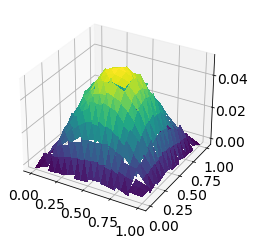

In [28]:
fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
trisurf(u_h, axes=ax)

## Dirac Delta 函数

通过数值积分公式实现 dirac delta 函数

In [14]:
from firedrake import *

from firedrake.petsc import PETSc
from pyop2 import op2
from pyop2.datatypes import ScalarType
from mpi4py import MPI
import finat
import numpy as np

import matplotlib.pyplot as plt

set_level(CRITICAL) # Disbale warnings


# TODO: change name to dirac_operator?
def delta_expr(m, x0):
    """Make dirac function at point

    Args:
        m: mesh
        x0: source point
    Return:
        delta function

    Example:
        delta = delta_expr(m, x0)
        f = Function(V)
        f_x0 = assemble(delta(f))
    """
    V = FunctionSpace(m, 'DG', 0)
    cell_marker = Function(V, name='cell_marker', dtype=ScalarType)
    qrule = finat.quadrature.make_quadrature(V.finat_element.cell, 0)
    cell, X = m.locate_cell_and_reference_coordinate(x0, tolerance=1e-6)

    # c = 0 if X is None else 1
    n_cell_local = len(cell_marker.dat.data)
    if X is not None and cell < n_cell_local:
        c = 1
    else:
        c = 0

    comm = m.comm
    s = comm.size - comm.rank
    n = comm.allreduce(int(s*c), op=MPI.MAX)

    if n == 0:
        raise BaseException("Points not found!")

    k = int(comm.size - n) # get the lower rank which include the point x0

    if c == 1 and comm.rank == k:
        X[X<0] = 0
        X[X>1] = 1
        cell_marker.dat.data[cell] = 1
        comm.bcast(X, root=k)
    else:
        cell_marker.dat.data[:] = 0 # we must set this otherwise the process will hangup
        X = comm.bcast(None, root=k)


    cell_marker.dat.global_to_local_begin(op2.READ)
    cell_marker.dat.global_to_local_end(op2.READ)

    qrule.point_set.points[0] = X
    qrule.weights[0] = qrule.weights[0]/np.real(assemble(cell_marker*dx))

    return lambda f: f*cell_marker*dx(rule=qrule)

测试 `delta_expr`

In [15]:
def test_dirca_delta():
    test_mesh = RectangleMesh(10, 10, 1, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    x2 = 0.333
    source = Constant([x1,x2])
    x0 = source
    delta = delta_expr(test_mesh, source)

    x, y = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**3 + y**3)

    expected_value =  g.at([x1, x2])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta()

value = 0.35553802400000073, expected value = 0.3555380240000015


Dirac delta 函数的 L2 投影

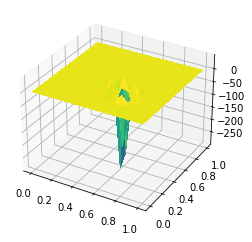

In [16]:
test_mesh = RectangleMesh(10, 10, 1, 1)
V = FunctionSpace(test_mesh, 'CG', 3)
delta = delta_expr(test_mesh, [0.638, 0.33])
bc = DirichletBC(V, 0, 'on_boundary')
u, v = TrialFunction(V), TestFunction(V)
sol = Function(V)
solve(u*conj(v)*dx == delta(conj(v)), sol, bcs=bc)

fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
trisurf(sol, axes=ax)

In [17]:
sol.dat.data.max(), sol.dat.data.min()

(788.6598262630521, -267.53195381302527)

求解源项为 Dirca delta 函数的 Possion 方程

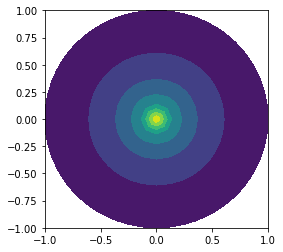

In [23]:
x0 = [0, 0]
# N = 500
# m = SquareMesh(N, N, 1)

m = UnitDiskMesh(refinement_level=3)

V = FunctionSpace(m, 'CG', 1)

v = TestFunction(V)
u = TrialFunction(V)

a = inner(grad(u), grad(v))*dx
L = delta_expr(m, x0)(v)
u = Function(V, name='u')

bc = DirichletBC(V, 0, 'on_boundary')

solve(a == L, u, bcs=bc)

# solve(a == L, u)
fig, ax = plt.subplots(figsize=[4, 4])
tricontourf(u, axes=ax)

## 自由度映射关系

### 编号

+ V.dim(): 自由度个数
+ V.cell_node_list: 局部编号与全局编号

In [29]:
mesh = RectangleMesh(8, 8, 1, 1)
V = FunctionSpace(mesh, 'CG', 1)
V.dim(), V.cell_node_list[:5]

(81,
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [1, 3, 5],
        [3, 4, 6]], dtype=int32))

__Example: 第一个三角形的坐标__

In [30]:
coords = mesh.coordinates

In [31]:
# get the cell node map
V_c = coords.function_space()
V_c.cell_node_list[:2]

array([[0, 1, 2],
       [1, 2, 3]], dtype=int32)

In [32]:
# another way to get the cell node map
coords.cell_node_map().values[:2]

array([[0, 1, 2],
       [1, 2, 3]], dtype=int32)

In [33]:
coords.dat.data_ro_with_halos[[0, 1, 2]]

array([[0.   , 0.   ],
       [0.   , 0.125],
       [0.125, 0.   ]])

### 有限元自由度

In [34]:
V = FunctionSpace(mesh, 'CG', 2)
# V.dim(), V.cell_node_list[:5]

element = V.finat_element

element.degree, element.cell,

(2, <FIAT.reference_element.UFCTriangle at 0x7fa86be29a60>)

In [35]:
V.finat_element.entity_dofs()

{0: {0: [0], 1: [1], 2: [2]}, 1: {0: [3], 1: [4], 2: [5]}, 2: {0: []}}

In [36]:
V.finat_element.entity_support_dofs()

{0: {0: [0], 1: [1], 2: [2]},
 1: {0: [1, 2, 3], 1: [0, 2, 4], 2: [0, 1, 5]},
 2: {0: [0, 1, 2, 3, 4, 5]}}

### 查看矩阵和向量 (PETSc)

[Introduction to PETSc](https://learn.tacc.utexas.edu/mod/page/view.php?id=96)

DOC: https://web.corral.tacc.utexas.edu/CompEdu/pdf/pcse/petsc_p_course.pdf

PETSc git repo: [petsc4py demo](https://gitlab.com/petsc/petsc/-/tree/main/src/binding/petsc4py/demo)

保存矩阵到文件: [matvecio.py](https://gitlab.com/petsc/petsc/-/blob/main/src/binding/petsc4py/demo/binary-io/matvecio.py)

In [37]:
test_mesh = RectangleMesh(nx=4, ny=4, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx

In [38]:
A = assemble(a)
b = assemble(L)
type(A), type(b)

(firedrake.matrix.Matrix, firedrake.function.Function)

In [39]:
type(A.petscmat)

petsc4py.PETSc.Mat

In [40]:
with b.dat.vec_ro as vec:
    print(type(vec))

<class 'petsc4py.PETSc.Vec'>


# NS 方程

Navier-Stocks 方程:
\begin{equation}
\left\{
\begin{aligned}
&\partial_t u - \mu\Delta u + (u\cdot\nabla)u + \nabla p = f, && {\rm in} \quad \Omega\times(0, T]\\
&\nabla\cdot u = 0, && {\rm in} \quad \Omega\times(0, T]
\end{aligned}
\right.
\end{equation}

初边值条件
\begin{equation}
\left\{
\begin{aligned}
& u = 0, && {\rm on} \quad \partial\Omega\times(0, T] \\
&u_0 = (y, -x) &&{\rm in} \quad \Omega\quad{\rm at}\quad t = 0\\
\end{aligned}
\right.
\end{equation}


In [41]:
from firedrake import *

mu = 1
T = 0.25

N_S = 16
N_T = 128

tau = T/N_T
h = 1/N_S

mesh = RectangleMesh(N_S, N_S, 1, 1)

x = SpatialCoordinate(mesh)
# u_0 = as_vector((x[1] - 0.5, - x[0] + 0.5))
u_0 = as_vector((x[1], - x[0]))
f = as_vector([0, -1])

## 函数空间

采用 MINI 元, 即 P1 $\times$ P1b.

P1b 由 P1 加上 Bubble 组成.

`NodalEnrichedElement`, `EnrichedElement`

`VectorFunctionSpace` 构造向量空间

In [42]:
cell = mesh.ufl_cell()
tdim = cell.topological_dimension()

# Mini element: P1 X P1b
P1 = FiniteElement("CG", cell, 1)
B = FiniteElement("B", cell, tdim+1)
P1b = P1 + B # or P1b = NodalEnrichedElement(P1, B)

V_u = VectorFunctionSpace(mesh, P1b)
V_p = FunctionSpace(mesh, "CG", 1)
V = MixedFunctionSpace([V_u, V_p])

## 弱形式

\begin{equation}
\left\{
\begin{aligned}
&\frac{1}{\tau}(u^n - u^{n-1}, v) + \mu(\nabla u^n, \nabla v) + ((u^n\cdot\nabla)u^n, v) - (p^n, \nabla\cdot v) = (f^n, v)\\
&(q, \nabla\cdot u^n) = 0
\end{aligned}
\right.
\end{equation}

+ `TrialFunctions`, `TestFunctions`: 

  以 `tuple` 返回函数空间中的试验/测试函数,

  主要用于 `MixedFunctionSpace`.
  
+ `split`, Function.split
    + `split`: 以索引的方式获取 `MixedFunctionSpace` 中函数的分量 (保留 UFL 关联信息, 用于定义变分形式)
    + `Function.split`: 以存储共享的方式获取分量 (生成新的变量, 只是共享原存储空间)

由于该问题是非线性问题, 我们打算用 `NonlinearVariationalSolver` 进行求解, 所以下面定义 `w` 使用了 `Function` 而不是 `TrialFunction`/`TrialFunctions`.

In [43]:
w = Function(V) # u and p
u, p = split(w)

v, q = TestFunctions(V)

w_nm1 = Function(V)
u_nm1, p_nm1 = w_nm1.split()
u_nm1.rename('u_h') # for visualization in paraview
p_nm1.rename('p_h')

Re = Constant(mu)

F = \
      Constant(1/tau)*inner(u - u_nm1, v)*dx \
    + Re*inner(grad(u+u_nm1)/2, grad(v))*dx \
    + inner(dot(grad(u), (u+u_nm1)/2), v)*dx \
    - p*div(v)*dx \
    + div(u)*q*dx \
    - inner(f, v)*dx

## 定义 Solver

类似于纯 Neumann 问题, 我们将使用 `nullspace` 参数.

注意下面混合空间中, 边界条件和 `nullspace` 的定义.

In [44]:
bc = DirichletBC(V.sub(0), 0, 'on_boundary')
nullspace = MixedVectorSpaceBasis(V, [V.sub(0), VectorSpaceBasis(constant=True)])

problem = NonlinearVariationalProblem(F, w, bcs=bc)  # F = 0
solver = NonlinearVariationalSolver(problem,
                                    options_prefix='ns',
                                    solver_parameters=None, # {'snes_converged_reason': None, 'snes_max_it': 100},
                                    nullspace=nullspace
                                   )

## 时间循环

In [45]:
from tqdm.notebook import tqdm # progress bar

u_, p_ = w.split()

output = File('pvd/ns-equation.pvd')

u_nm1.project(u_0)
output.write(u_nm1, p_nm1, time=0)

for i in  tqdm(range(N_T)):
    t = tau*(i+1)
    
    solver.solve()
    
    u_nm1.assign(u_)
    p_nm1.assign(p_)

    output.write(u_nm1, p_nm1, time=t)

  0%|          | 0/128 [00:00<?, ?it/s]

### Constant 用于时间依赖的表达式

In [46]:
from firedrake import *
mesh = RectangleMesh(10, 10, 1, 1)
C1 = Constant(0)

x, y = SpatialCoordinate(mesh)
expr = C1*(x+y)

v = []
for i in range(5):
    t = i*0.1
    C1.assign(t)
    v.append(
        assemble(expr*dx)
    )

print(v)

[0.0, 0.09999999999999991, 0.19999999999999982, 0.29999999999999966, 0.39999999999999963]


## ParaView 可视化计算结果

Pipeline 和 Filter

### 二维结果 (surf 图)

Filter: Wrap by scalar

### 选择部分区域显示

View -> Find Data



# 多进程并行 (MPI 和 PETSc)

使用 `mpiexec` 运行 python 文件即可.

我们使用 `ipyparallel` 介绍并行程序的一些内容, 需要先安装 `ipyparallel`

In [25]:
import ipyparallel as ipp
import os

cluster = ipp.Cluster(profile="mpi", n=2)
client = cluster.start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

## DMPlex

并行时, 网格会被划分成不同的块, 分配到各个进程.

网格由 `PETSc` 中的 `DMPlex` 管理.

DMPlex Reference:
1. [Lange, M., Mitchell, L., Knepley, M. G., & Gorman, G. J. Efficient mesh management in firedrake using PETSC DMPLEX. SISC, 2016, 38(5), S143-S155.]( https://epubs.siam.org/doi/10.1137/20M1332748)
2. 
[Hapla, V., Knepley, M. G., Afanasiev, M., Boehm, C., van Driel, M., Krischer, L., & Fichtner, A. Fully parallel mesh I/O using PETSc DMPlex with an application to waveform modeling. SISC, 2021, 43(2), C127-C153.](https://epubs.siam.org/doi/abs/10.1137/15M1026092)

In [2]:
%%px --block 
from firedrake import *

mesh = RectangleMesh(8, 8, 1, 1)
mesh.topology_dm.view()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] DM Object: firedrake_default_topology 2 MPI processes
  type: plex
firedrake_default_topology in 2 dimensions:
  Number of 0-cells per rank: 45 45
  Number of 1-cells per rank: 108 108
  Number of 2-cells per rank: 64 64
Labels:
  depth: 3 strata with value/size (0 (45), 1 (108), 2 (64))
  celltype: 3 strata with value/size (0 (45), 1 (108), 3 (64))
  Face Sets: 2 strata with value/size (1 (8), 3 (8))
  exterior_facets: 1 strata with value/size (1 (16))
  interior_facets: 1 strata with value/size (1 (92))


## Star Forest

Reference:
  
  [1] J. Zhang et al., [The PetscSF Scalable Communication Layer](https://arxiv.org/pdf/2102.13018.pdf), IEEE Transactions on Parallel and Distributed Systems, 33(4), 2022. 

In [3]:
%%px --block
from firedrake import *
from firedrake.petsc import PETSc

from petsc4py import PETSc
import numpy as np

# 6--------7--------8
# |        |        |
# 3--------4--------5
# |        |        |
# 0--------1--------2

def test_SFDistributeSection():
    comm = COMM_WORLD
    if comm.rank == 0:
        cells = np.asarray(
            [[0, 1, 3],
             [1, 2, 4],
             [1, 4, 3],
             [2, 5, 4],
             [3, 4, 6],
             [4, 5, 7],
             [4, 7, 6],
             [5, 8, 7]], dtype=np.int32)
        coords = np.asarray(
            [[0. , 0. ],
             [0.5, 0. ],
             [1. , 0. ],
             [0. , 0.5],
             [0.5, 0.5],
             [1.0, 0.5],
             [0. , 1. ],
             [0.5, 1. ],
             [1. , 1. ]], dtype=np.double)
    else:
        cells = np.zeros([0, 3], dtype=np.int32)
        coords = np.zeros([0, 2], dtype=np.double)
    dim = 2
    plex = PETSc.DMPlex().createFromCellList(dim, cells, coords, comm=comm)
    rootSection = PETSc.Section().create(comm=comm)
    pStart, pEnd = plex.getHeightStratum(2)
    rootSection.setChart(*plex.getChart())
    for p in range(pStart, pEnd):
        rootSection.setDof(p, 1)
    rootSection.setUp()
    rootSection.viewFromOptions('-section_view')

    dplex = plex.clone()
    msf = dplex.distribute()

    if msf is None:
        PETSc.Sys.Print("Warning: plex has not been distributed!")
        return
    dplex.viewFromOptions('-dm_view')

    def isEqualSF(ssf0, ssf1):
        nroots0, local0, remote0 = ssf0.getGraph()
        nroots1, local1, remote1 = ssf1.getGraph()
        return (nroots0 == nroots1) \
                and np.array_equal(local0, local1) \
                and np.array_equal(remote0, remote1)

    remoteOffsets0, leafSection0 = msf.distributeSection(rootSection)
    ssf0 = msf.createSectionSF(rootSection, remoteOffsets0, leafSection0)

    remoteOffsets1, leafSection1 = msf.distributeSection(rootSection, None)
    ssf1 = msf.createSectionSF(rootSection, remoteOffsets1, leafSection1)

    leafSection2 = PETSc.Section()
    remoteOffsets2, leafSection2 = msf.distributeSection(rootSection, leafSection2)
    ssf2 = msf.createSectionSF(rootSection, remoteOffsets2, leafSection2)

    leafSection3 = PETSc.Section()
    remoteOffsets3, _ = msf.distributeSection(rootSection, leafSection3)
    ssf3 = msf.createSectionSF(rootSection, remoteOffsets3, leafSection3)

    leafSection4 = PETSc.Section().create(dplex.getComm())
    remoteOffsets4, leafSection4 = msf.distributeSection(rootSection, leafSection4)
    ssf4 = msf.createSectionSF(rootSection, remoteOffsets4, leafSection4)

    leafSection5 = PETSc.Section().create(dplex.getComm())
    remoteOffsets5, _ = msf.distributeSection(rootSection, leafSection5)
    ssf5 = msf.createSectionSF(rootSection, remoteOffsets5, leafSection5)

    assert isEqualSF(ssf0, ssf1)
    assert isEqualSF(ssf0, ssf2)
    assert isEqualSF(ssf0, ssf3)
    assert isEqualSF(ssf0, ssf4)
    ssf0.view()


In [4]:
%%px --block
# Add back after upgrad the firedrake
test_SFDistributeSection()

[stdout:0] PetscSF Object: 2 MPI processes
  type: basic
  [0] Number of roots=9, leaves=6, remote ranks=1
  [0] 0 <- (0,0)
  [0] 1 <- (0,1)
  [0] 2 <- (0,3)
  [0] 3 <- (0,4)
  [0] 4 <- (0,6)
  [0] 5 <- (0,7)
  [1] Number of roots=0, leaves=6, remote ranks=1
  [1] 0 <- (0,1)
  [1] 1 <- (0,2)
  [1] 2 <- (0,4)
  [1] 3 <- (0,5)
  [1] 4 <- (0,7)
  [1] 5 <- (0,8)
  MultiSF sort=rank-order


## 输出

[intro_utils.py](intro_utils.py)

In [49]:
%%px --block 
from firedrake import *
from firedrake.petsc import PETSc
from mpi4py import MPI

PETSc.Sys.Print('This is first line (from rank 0)')

[stdout:0] This is first line (from rank 0)


In [50]:
%%px --block 
PETSc.Sys.syncPrint('This is second line (from all rank)')
PETSc.Sys.syncFlush()

[stdout:0] This is second line (from all rank)
This is second line (from all rank)


In [51]:
%%px --block
print('This msg from all rank')

[stdout:0] This msg from all rank


[stdout:1] This msg from all rank


## communicator

In [52]:
%%px --block

mesh = RectangleMesh(8, 8, 1, 1)
PETSc.Sys.syncPrint(mesh.comm.rank, mesh.comm.size)
PETSc.Sys.syncFlush()

[stdout:0] 0 2
1 2


In [53]:
%%px --block

PETSc.Sys.syncPrint(COMM_WORLD.rank, COMM_WORLD.size)
PETSc.Sys.syncFlush()

[stdout:0] 0 2
1 2


In [ ]:
%%px --block

PETSc.Sys.syncPrint(COMM_SELF.rank, COMM_SELF.size)
PETSc.Sys.syncFlush()

[stdout:0] 0 1
0 1


有些时候需要在某个进程上, 做指定的操作或运算, 如只在第0个进程上画图

```python
if COMM_WORLD.rank == 0:
    plot(...)
```

# Debug

## 常见问题

###  DIVERGED_LINEAR_SOLVE

The errors are like this.
```python
File "/home/yzz/firedrake/src/firedrake/firedrake/adjoint/solving.py", line 50, in wrapper
    output = solve(*args, **kwargs)
  File "/home/yzz/firedrake/src/firedrake/firedrake/solving.py", line 129, in solve
    _solve_varproblem(*args, **kwargs)
  File "/home/yzz/firedrake/src/firedrake/firedrake/solving.py", line 161, in _solve_varproblem
    solver.solve()
  File "/home/yzz/firedrake/src/firedrake/firedrake/adjoint/variational_solver.py", line 75, in wrapper
    out = solve(self, **kwargs)
  File "/home/yzz/firedrake/src/firedrake/firedrake/variational_solver.py", line 278, in solve
    solving_utils.check_snes_convergence(self.snes)
  File "/home/yzz/firedrake/src/firedrake/firedrake/solving_utils.py", line 139, in check_snes_convergence
    raise ConvergenceError(r"""Nonlinear solve failed to converge after %d nonlinear iterations.
firedrake.exceptions.ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINEAR_SOLVE
```

Reasons for this:
1. You equation is not closed. May be you write wrong boundary conditions. Check the boundary condition carefully.
2. The resulting system is singular? ## Maybe
3. ...

### PyErr_Occurred

```python
python: src/petsc4py.PETSc.c:348918: __Pyx_PyCFunction_FastCall: Assertion `!PyErr_Occurred()' failed.
```

This may caused by your python code (with pragrammer error, such as undefined variables) called by PETSc

### Tips

在程序开始添加如下代码, 可能会有更详细信息
```
PETSc.Sys.popErrorHandler()
```

## 调试 Python 代码
运行中抛出异常, 定位出错代码, 检查相关的变量是否有异常值存在. 例如在 Jupyter notebook 中, `%debug` 可打开调试器, 检查相关变量.

## 调试 C 代码 (gdb)

由于 firedrake 基于 PETSc 进行网格管理和线性方程组求解, 有时出错会在 PETSc 中, 例如运行如下代码:

TODO: 找个示例, 这个示例不行
```python
# filename: test.py
import sys
import petsc4py
petsc4py.init(sys.argv)
from petsc4py import PETSc
if PETSc.COMM_WORLD.rank == 0:
    PETSc.Vec().create(comm=PETSc.COMM_SELF).view()
```
出错信息如下:
```
$ python test.py
Vec Object: 1 MPI process
  type not yet set
Traceback (most recent call last):
  File "test.py", line 7, in <module>
    PETSc.Vec().create(comm=PETSc.COMM_SELF).view()
  File "PETSc/Vec.pyx", line 140, in petsc4py.PETSc.Vec.view
petsc4py.PETSc.Error: error code 56
[0] VecView() at /home/yzz/software/firedrake-mini-petsc/src/petsc/src/vec/vec/interface/vector.c:715
[0] No support for this operation for this object type
[0] No method view for Vec of type (null)
```


这时可以使用 gdb 等调试工具. 

### gdb 命令行说明
```
gdb [options] --args executable-file [inferior-arguments ...]
```

### 参数 (options)
1. `-ex COMMAND`: 执行 gdb 命令
2. `--args exe [exe-args]` 传递参数给 exe
3. `--pid <pid>` 调试正在运行的程序

### gdb 命令:
1. `bt`: 查看函数调用栈
2. `run`: 运行可执行文件
3. `l`: 查看代码
4. `p`: 打印变量


### 示例 (调试 `test.py`)
```
$ gdb  -ex run --args $(which python3) test.py
```

## 并行程序调试

### `PETSc` 的参数 `-start_in_debugger`

Reference: 
1. https://petsc.org/main/docs/manualpages/Sys/PetscInitialize/
2. https://petsc.org/main/docs/manualpages/Sys/PetscSetDebugTerminal/

可以选择使用 `PETSc` 的参数 `-start_in_debugger` 给每个进程启动调试器如下:
```bash
mpiexec -n 3 $(which python) test.py  -start_in_debugger
```
默认会启动多个 xterm 窗口. 

_Notes_: 修改 xterm 窗口显示效果 (Ref: http://www.futurile.net/2016/06/14/xterm-setup-and-truetype-font-configuration/)
```
$ cat ~/.Xdefaults
xterm*faceName: Monospace
xterm*faceSize: 12
xterm*foreground: rgb:a8/a8/a8
xterm*background: rgb:00/00/00
```

### 工具 `tmux-mpi`


Reference: https://github.com/firedrakeproject/firedrake/wiki/Parallel-MPI-Debugging-with-tmux-mpi

另外我们也可以选择使用工具 `tmux-mpi`. 

#### 安装 tmux-mpi

1. 安装 tmux 
    
    ```bash
    sudo apt-get install tmux
    ```

2. 安装 dtach (tmux-mpi 依赖)

    先编译 dtach, 然后拷贝二进制文件到某个在 PATH 中的路径, 如 $HOME/bin.

    ```bash
    git clone https://github.com/crigler/dtach
    cd dtach
    ./configure
    make
    cp dtach $HOME/bin
    ```

    运行 `which dtach` 确认安装是否成功
    
3. 安装 tmux-mpi

    使用 pip 安装
    ```bash
    pip install --upgrade --no-cache-dir git+https://github.com/wrs20/tmux-mpi@master
    ```


#### 调试命令

1. 启动调试器
    ```bash
    tmux-mpi 3 gdb -ex run --args $(which python) test.py
    ```


2. Attach 到相应的的伪终端, 每个进程一个窗口. (这里是 tmux 的一个 session, 有多个 window)
    
    ```bash
    tmux attach -t tmux-mpi
    ```


3. 使用 gdb 调试命令调试